We import the libraries that we are going to use.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve,roc_auc_score, precision_score, recall_score,ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

In [2]:
# Import dataset
print("Loading dataset...")
dataset = pd.read_csv("conversion_data_train.csv")
print("...Done.")
print()

Loading dataset...
...Done.



In [3]:
# Basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])


Number of rows : 284580

Display of dataset: 


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0



Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [4]:
dataset['country'].value_counts()

US         160124
China       69122
UK          43641
Germany     11693
Name: country, dtype: int64

In [5]:
dataset['source'].value_counts()

Seo       139477
Ads        80027
Direct     65076
Name: source, dtype: int64

Probability of conversion based on categorical variables.

In [6]:
dataset.groupby('country')['converted'].mean()

country
China      0.001288
Germany    0.062431
UK         0.052497
US         0.037908
Name: converted, dtype: float64

About 6% of Germans have converted, 5% of English and 4% of Americans. On the other hand, only 0.1% of Chinese have converted. Nationality seems to influence the likelihood of converting, especially between Chinese and the other three nationalities.

In [7]:
dataset.groupby('source')['converted'].mean()

source
Ads       0.034801
Direct    0.027814
Seo       0.032873
Name: converted, dtype: float64

The source seems to have relatively little influence on the probability of converting.

In [8]:
dataset.groupby('new_user')['converted'].mean()

new_user
0    0.071933
1    0.014052
Name: converted, dtype: float64

It seems that new users are less attracted to converting.

The following is a logistic regression that plots the probability of conversion based on the number of pages visited.

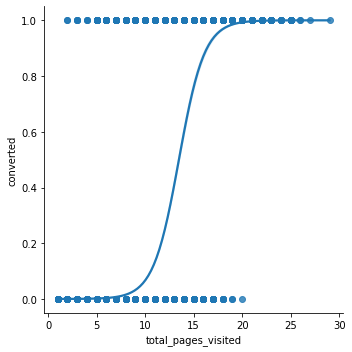

In [9]:
sns.lmplot(data=dataset.sample(frac = 0.2),x="total_pages_visited",y="converted",logistic = True)

The number of pages visited seems to greatly influence the probability of converting.

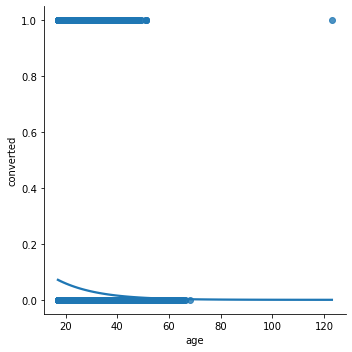

In [10]:
sns.lmplot(data=dataset.sample(frac = 0.2),x="age",y="converted",logistic = True);

The probability of converting does not seem to be influenced by age except for people which are older that 80 years old, but this is probably a very small number of people. This is checked immediately by determining the percentage of individuals who are over 75 years old.

In [11]:
dataset.corr()

,age,new_user,total_pages_visited,converted
age,1.000000,0.011676,-0.045365,-0.088265
new_user,0.011676,1.000000,-0.082986,-0.152115
total_pages_visited,-0.045365,-0.082986,1.000000,0.529192
converted,-0.088265,-0.152115,0.529192,1.000000


Function that gives the main metrics, ROC and AUC curves

In [12]:
def table_scores(y_trues,y_preds,y_probs):
    
    # y_trues=(y_train,y_test) et y_preds=(y_train_pred,y_test_pred)
    
    acc_train = accuracy_score(y_trues[0],y_preds[0])
    
    acc_test = accuracy_score(y_trues[1],y_preds[1])
    
    f1_train = f1_score(y_trues[0],y_preds[0])
    
    f1_test = f1_score(y_trues[1],y_preds[1])
    
    precision_train = precision_score(y_trues[0],y_preds[0])
    
    precision_test = precision_score(y_trues[1],y_preds[1])
    
    recall_train = recall_score(y_trues[0],y_preds[0])
    
    recall_test = recall_score(y_trues[1],y_preds[1])
    
    auc_train = roc_auc_score(y_trues[0],y_probs[0])
    
    auc_test = roc_auc_score(y_trues[1],y_probs[1])
    
    dict_scores = {'Accuracy' : [acc_train,acc_test] , 'f1_score' : [f1_train,f1_test],
                   'precision' : [precision_train,precision_test] , 'recall' : [recall_train,recall_test],
                   'auc' : [auc_train,auc_test]}
    
    df = round(pd.DataFrame(data = dict_scores , index = ['train','test']),2)
    
   
    fper, tper, thresholds = roc_curve(y_trues[0], y_probs[0])
    fig = go.Figure(
    data = go.Scatter(
        name = 'train',
        x = fper, 
        y = tper, 
        mode = 'lines'
    ),
    layout = go.Layout(
        title = go.layout.Title(text = "ROC curve", x = 0.5),
        xaxis = go.layout.XAxis(title = 'False Positive Rate'),
        yaxis = go.layout.YAxis(title = 'True Positive Rate')
    )
    )

    fper, tper, thresholds = roc_curve(y_trues[1], y_probs[1])
    fig.add_trace(go.Scatter(
    name = 'test',
    x = fper, 
    y = tper, 
    mode = 'lines'
    )
    )

    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
     print(df)
     return fig

## Pre-processing.

In [56]:
# Separate target variable Y from features X
target_name = 'converted'

print("Separating labels from features...")
y = dataset.loc[:,target_name]
X = dataset.loc[:,[c for c in dataset.columns if c!=target_name]] # All columns are kept, except the target
#                                                                                  
print("...Done.")
print(y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

   country  age  new_user  source  total_pages_visited
0    China   22         1  Direct                    2
1       UK   21         1     Ads                    3
2  Germany   20         0     Seo                   14
3       US   23         1     Seo                    3
4       US   28         1  Direct                    3



We use a one-to-encoder on the "country" column and eliminate the "UK" column.

In [57]:
encoder_country = OneHotEncoder(sparse = False).fit(X[['country']])

cols_enc = [col for col in encoder_country.categories_[0]]

X = X.join(pd.DataFrame(encoder_country.transform(X[['country']]),columns = cols_enc)).drop(columns = "UK")

X.head()

,country,age,new_user,source,total_pages_visited,China,Germany,US
0,China,22,1,Direct,2,1.0,0.0,0.0
1,UK,21,1,Ads,3,0.0,0.0,0.0
2,Germany,20,0,Seo,14,0.0,1.0,0.0
3,US,23,1,Seo,3,0.0,0.0,1.0
4,US,28,1,Direct,3,0.0,0.0,1.0


We do the same for source and eliminate "Direct" column.

In [58]:
encoder_source = OneHotEncoder(sparse = False,drop = 'first').fit(X[['source']])

cols_enc = [col for col in encoder_source.categories_[0][1:]]

X = X.join(pd.DataFrame(encoder_source.transform(X[['source']]),columns = cols_enc))

X.head()

,country,age,new_user,source,total_pages_visited,China,Germany,US,Direct,Seo
0,China,22,1,Direct,2,1.0,0.0,0.0,1.0,0.0
1,UK,21,1,Ads,3,0.0,0.0,0.0,0.0,0.0
2,Germany,20,0,Seo,14,0.0,1.0,0.0,0.0,1.0
3,US,23,1,Seo,3,0.0,0.0,1.0,0.0,1.0
4,US,28,1,Direct,3,0.0,0.0,1.0,1.0,0.0


In [59]:
X = X.drop(columns = ['country','source'])

X.head()

,age,new_user,total_pages_visited,China,Germany,US,Direct,Seo
0,22,1,2,1.0,0.0,0.0,1.0,0.0
1,21,1,3,0.0,0.0,0.0,0.0,0.0
2,20,0,14,0.0,1.0,0.0,0.0,1.0
3,23,1,3,0.0,0.0,1.0,0.0,1.0
4,28,1,3,0.0,0.0,1.0,1.0,0.0


In [60]:
# First : always divide dataset into train set & test set !!
print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)
# test_size indicates the proportion of rows from X and Y that will go into the test dataset while 
# maintaining the correspondance between the rows from X and Y 

# random_state is an argument that can be found in all functions that have a pseudo-random behaviour
# if random_state is not stated the function will derive a different random result everytime the cell 
# runs, if random_state is given a value the results will be the same everytime the cell runs while
# each different value of radom_state will derive a specific result
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [61]:
X_train.columns

Index(['age', 'new_user', 'total_pages_visited', 'China', 'Germany', 'US',
       'Direct', 'Seo'],
      dtype='object')

We standardize the numeric columns, i.e.: "age", "total_pages_visited".

In [62]:
sc = StandardScaler()

X_train[['age','total_pages_visited']] = sc.fit_transform(X_train[['age','total_pages_visited']])

X_test[['age','total_pages_visited']] = sc.transform(X_test[['age','total_pages_visited']])

Vérifions que la standarisation a bien fonctionné.

In [63]:
print('Moyenne des deux variables numériques sur le train:' , np.array(X_train[['age','total_pages_visited']].mean()))
print('Moyenne des deux variables numériques sur le test:' , np.array(X_test[['age','total_pages_visited']].mean()))
print('Ecart type des deux variables numériques sur le train:' , np.array(X_train[['age','total_pages_visited']].std()))
print('Ecart type des deux variables numériques sur le test:' , np.array(X_test[['age','total_pages_visited']].std()))

Moyenne des deux variables numériques sur le train: [ 1.10637052e-16 -3.72498492e-16]
Moyenne des deux variables numériques sur le test: [-0.00702151 -0.00245099]
Ecart type des deux variables numériques sur le train: [1.0000022 1.0000022]
Ecart type des deux variables numériques sur le test: [0.99575278 0.99956221]


# Baseline model : simple logistic regression

### We first consider all features.

In [64]:
# Train model

print("Train model...")
#classifier = KNeighborsClassifier()
classifier = LogisticRegression(penalty = 'l1',solver = 'liblinear')

param_grid = {'C' : [10**k for k in range(-7,8)]}

gsLR = GridSearchCV(estimator = classifier , param_grid = param_grid , scoring='f1',
                     cv=5,
                     refit=True,
                     n_jobs=1,error_score='raise')

#classifier = SVC()
gsLR.fit(X_train, y_train)
print("...Done.")

Train model...
...Done.


In [65]:
# Test model

classifier = gsLR.best_estimator_

In [66]:
# Predictions on train set
y_train_pred = classifier.predict(X_train)
# Predictions on test set
print("Predictions on test set...")
y_test_pred = classifier.predict(X_test)
print("...Done.")
print(y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



       Accuracy  f1_score  precision  recall   auc
train      0.99      0.77       0.86    0.69  0.99
test       0.99      0.75       0.85    0.68  0.99


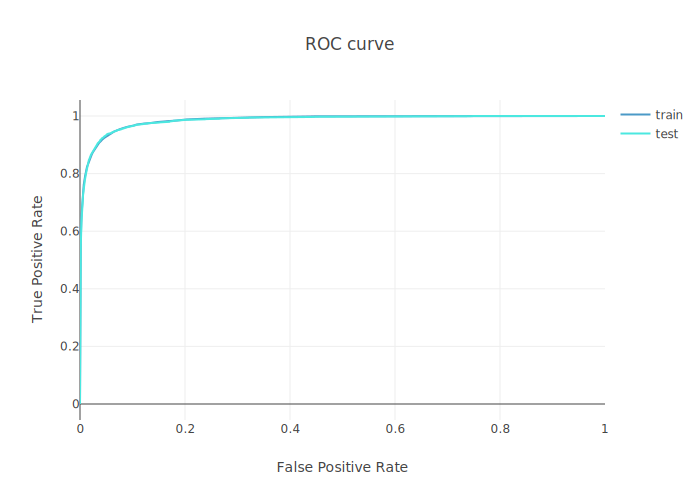

In [67]:
probas_train1 = classifier.predict_proba(X_train)[:,1]

probas_test1 = classifier.predict_proba(X_test)[:,1]

fig = table_scores([y_train,y_test],[y_train_pred,y_test_pred],[probas_train1,probas_test1])

fig.show()

We display the logistic regression coefficients for each feature.

In [68]:
pd.DataFrame(index = X_train.columns.tolist(), data = classifier.coef_.T , columns = ['coefficients'])

,coefficients
age,-0.594172
new_user,-1.691503
total_pages_visited,2.550974
China,-3.585954
Germany,0.158214
US,-0.376265
Direct,-0.195854
Seo,-0.043507


The variable "source" seems to have little influence on the variable "converted".

The variables "source" and "age" are eliminated.

In [69]:
X_train2 = X_train[[col for col in X_train.columns if col not in dataset["source"].unique().tolist()+["age"]]]

X_test2 = X_test[[col for col in X_train.columns if col not in dataset["source"].unique().tolist()+["age"]]]

X_train2.head()

,new_user,total_pages_visited,China,Germany,US
137434,1,-1.159353,1.0,0.0,0.0
112323,1,0.037432,0.0,0.0,1.0
143261,1,-0.860157,0.0,0.0,1.0
162328,0,-1.159353,1.0,0.0,0.0
158039,1,0.037432,1.0,0.0,0.0


In [70]:
classifier = LogisticRegression(penalty = 'l1',solver = 'liblinear')

param_grid = {'C' : [10**k for k in range(-7,8)]}

gsLR = GridSearchCV(estimator = classifier , param_grid = param_grid , scoring='f1',
                     cv=5,
                     refit=True,
                     n_jobs=1,error_score='raise')

#classifier = SVC()
gsLR.fit(X_train2, y_train)
print("...Done.")

...Done.


In [71]:
classifier = gsLR.best_estimator_
# Predictions on train set
y_train_pred2 = classifier.predict(X_train2)
# Predictions on test set
print("Predictions on test set...")
y_test_pred2 = classifier.predict(X_test2)
print("...Done.")
print(y_test_pred2)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



       Accuracy  f1_score  precision  recall   auc
train      0.99      0.75       0.85    0.67  0.98
test       0.99      0.74       0.84    0.66  0.98


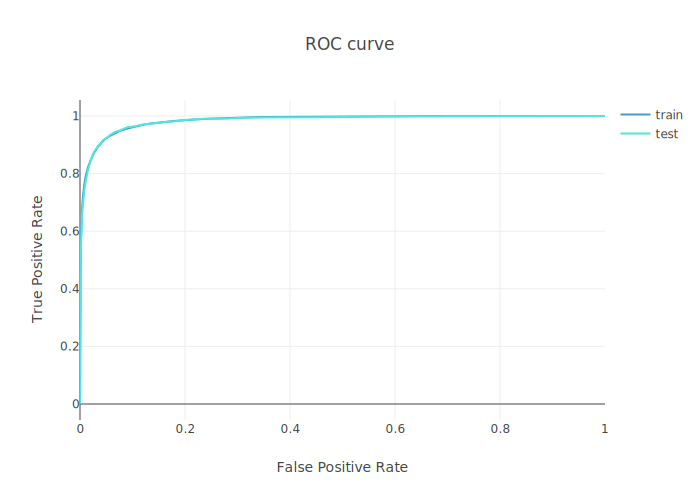

In [72]:
probas_train2 = classifier.predict_proba(X_train2)[:,1]

probas_test2 = classifier.predict_proba(X_test2)[:,1]

fig = table_scores([y_train,y_test],[y_train_pred2,y_test_pred2],[probas_train2,probas_test2])

fig.show()

The results are not bad. To test several models at once, we define a function that allows grid-search with several models at once and to return the metrics of each model whose hyper-parameters have been optimized.

In [73]:
# data_model = {name_model : [model,param_grid]}

# Example: data_model = {'LR' : [LR(),{'C':[1,2,4]}]}

def models_grid_search(data_model,X_train,y_train,X_test,y_test,scores = [accuracy_score,f1_score,precision_score,recall_score]):
    
    name_scores = [str(score).split('function ')[1].split(' at')[0] for score in scores]
    metrics_models = []
    cols_dataset_metrics = [f'{name_score} train' for name_score in name_scores] + \
    [f'{name_score} test' for name_score in name_scores]
    new_cols_dataset_metrics = []

    for l in [[f'{name_score} train'] + [f'{name_score} test'] for name_score in name_scores]:
    
      new_cols_dataset_metrics += l


    best_estimators = dict()
    
    for model_name , model_info in data_model.items():
        print("**************************************************************************")
        print("*********************",model_name,"***************************************")
        print("**************************************************************************")
        model = model_info[0]
        param_grid = model_info[1]
        gs_model = GridSearchCV(estimator = model , param_grid = param_grid , scoring='f1',
                     cv=5,
                     refit=True,
                     n_jobs=1,error_score=np.nan)
        gs_model.fit(X_train,y_train)
        best_estimator = gs_model.best_estimator_
        best_estimators.update({model_name:best_estimator})
        y_train_pred = best_estimator.predict(X_train)
        y_test_pred = best_estimator.predict(X_test)
        metrics_model = [round(score(y_train,y_train_pred),2) for score in scores]
        metrics_model = metrics_model + [round(score(y_test,y_test_pred),2) for score in scores]
        metrics_models.append(metrics_model)   
        
    metrics_models_df = pd.DataFrame(data = metrics_models,columns = cols_dataset_metrics, index = data_model.keys())  
    metrics_models_df = metrics_models_df[new_cols_dataset_metrics]
    return best_estimators,metrics_models_df
    

The data_models dictionary indicates the models we train and the hyperparameters we optimize.

In [74]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

data_models = {'LR' : [LogisticRegression(max_iter = 1000),{'penalty': ['l2', 'none']
                                             , 'C': np.linspace(0.01, 5, 10)}]
              ,'knn' : [KNeighborsClassifier(),{'n_neighbors':[5,50,500]}]
              ,'Random Forest' : [RandomForestClassifier(),{"n_estimators": [ 25, 100], 'max_depth': range(2, 11, 4)
                                                            , 'min_samples_split': [2, 5, 10]}]
               ,'Decision tree' : [DecisionTreeClassifier(),dict()]
              ,'XGBOOST' : [XGBClassifier(objective= 'binary:logistic'),{'max_depth': range (2, 10, 4),
     'n_estimators': range(60, 220, 70),
     'learning_rate': [0.1, 0.01, 0.05]}]}
             

We try with all the features.

In [75]:
best_estimators,metrics_models_df = models_grid_search(data_models,X_train,y_train,X_test,y_test,scores = [f1_score])

**************************************************************************
********************* LR ***************************************
**************************************************************************
**************************************************************************
********************* knn ***************************************
**************************************************************************
**************************************************************************
********************* Random Forest ***************************************
**************************************************************************
**************************************************************************
********************* Decision tree ***************************************
**************************************************************************
**************************************************************************
********************* XGBOOST ************

In [76]:
best_estimators

{'LR': LogisticRegression(C=0.01, max_iter=1000, penalty='none'),
 'knn': KNeighborsClassifier(n_neighbors=50),
 'Random Forest': RandomForestClassifier(max_depth=10, min_samples_split=10),
 'Decision tree': DecisionTreeClassifier(),
 'XGBOOST': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=200,
               n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, ...)}

In [77]:
metrics_models_df

,f1_score train,f1_score test
LR,0.77,0.75
knn,0.76,0.75
Random Forest,0.78,0.75
Decision tree,0.80,0.72
XGBOOST,0.77,0.76


It is redone by eliminating the "source" feature.

In [78]:
X_train3 = X_train[[col for col in X_train.columns if col not in dataset['source'].unique()]]
X_test3 = X_test[[col for col in X_train.columns if col not in dataset['source'].unique()]]

In [79]:
best_estimators2,metrics_models_df2 = models_grid_search(data_models,X_train3,y_train,X_test3,y_test,scores = [f1_score])

**************************************************************************
********************* LR ***************************************
**************************************************************************
**************************************************************************
********************* knn ***************************************
**************************************************************************
**************************************************************************
********************* Random Forest ***************************************
**************************************************************************
**************************************************************************
********************* Decision tree ***************************************
**************************************************************************
**************************************************************************
********************* XGBOOST ************

In [80]:
metrics_models_df2

,f1_score train,f1_score test
LR,0.77,0.76
knn,0.76,0.75
Random Forest,0.78,0.75
Decision tree,0.78,0.74
XGBOOST,0.77,0.75


In [81]:
X_train3.columns

Index(['age', 'new_user', 'total_pages_visited', 'China', 'Germany', 'US'], dtype='object')

The variables "age" and "source" are eliminated.

In [82]:
X_train4 = X_train3[[col for col in X_train3.columns if col != "age"]]
X_test4 = X_test3[[col for col in X_train3.columns if col != "age"]]

In [83]:
X_train4.head()

,new_user,total_pages_visited,China,Germany,US
137434,1,-1.159353,1.0,0.0,0.0
112323,1,0.037432,0.0,0.0,1.0
143261,1,-0.860157,0.0,0.0,1.0
162328,0,-1.159353,1.0,0.0,0.0
158039,1,0.037432,1.0,0.0,0.0


In [84]:
best_estimators3,metrics_models_df3 = models_grid_search(data_models,X_train4,y_train,X_test4,y_test,scores = [f1_score])

**************************************************************************
********************* LR ***************************************
**************************************************************************
**************************************************************************
********************* knn ***************************************
**************************************************************************
**************************************************************************
********************* Random Forest ***************************************
**************************************************************************
**************************************************************************
********************* Decision tree ***************************************
**************************************************************************
**************************************************************************
********************* XGBOOST ************

In [85]:
metrics_models_df3

,f1_score train,f1_score test
LR,0.75,0.74
knn,0.75,0.74
Random Forest,0.75,0.74
Decision tree,0.75,0.74
XGBOOST,0.75,0.74


The variables "new_user" and "source" are eliminated.

In [86]:
X_train5 = X_train3[[col for col in X_train3.columns if col != "new_user"]]
X_test5 = X_test3[[col for col in X_train3.columns if col != "new_user"]]

In [87]:
best_estimators4,metrics_models_df4 = models_grid_search(data_models,X_train5,y_train,X_test5,y_test,scores = [f1_score])

**************************************************************************
********************* LR ***************************************
**************************************************************************
**************************************************************************
********************* knn ***************************************
**************************************************************************
**************************************************************************
********************* Random Forest ***************************************
**************************************************************************
**************************************************************************
********************* Decision tree ***************************************
**************************************************************************
**************************************************************************
********************* XGBOOST ************

In [88]:
metrics_models_df4

,f1_score train,f1_score test
LR,0.74,0.72
knn,0.74,0.71
Random Forest,0.74,0.72
Decision tree,0.74,0.70
XGBOOST,0.74,0.72


In [89]:
X_train5.columns

Index(['age', 'total_pages_visited', 'China', 'Germany', 'US'], dtype='object')

We summarize all the metrics in a single dataframe.

In [90]:
metrics_models_df['estimators'] = "best_estimators"
metrics_models_df2['estimators'] = "best_estimators2"
metrics_models_df3['estimators'] = "best_estimators3"
metrics_models_df4['estimators'] = "best_estimators4"

In [91]:
X_train2.columns.tolist()

['new_user', 'total_pages_visited', 'China', 'Germany', 'US']

In [92]:
metrics_models_df['features'] = str(X_train.columns.tolist())
metrics_models_df2['features'] = str(X_train3.columns.tolist())
metrics_models_df3['features'] = str(X_train4.columns.tolist())
metrics_models_df4['features'] = str(X_train5.columns.tolist())

In [93]:
final_resume_metrics = pd.concat([metrics_models_df,metrics_models_df2,metrics_models_df3,metrics_models_df4],axis = 0)

In [94]:
final_resume_metrics.sort_values('f1_score test',ascending = False)

,f1_score train,f1_score test,estimators,features
XGBOOST,0.77,0.76,best_estimators,"['age', 'new_user', 'total_pages_visited', 'Ch..."
LR,0.77,0.76,best_estimators2,"['age', 'new_user', 'total_pages_visited', 'Ch..."
LR,0.77,0.75,best_estimators,"['age', 'new_user', 'total_pages_visited', 'Ch..."
Random Forest,0.78,0.75,best_estimators,"['age', 'new_user', 'total_pages_visited', 'Ch..."
knn,0.76,0.75,best_estimators2,"['age', 'new_user', 'total_pages_visited', 'Ch..."
Random Forest,0.78,0.75,best_estimators2,"['age', 'new_user', 'total_pages_visited', 'Ch..."
XGBOOST,0.77,0.75,best_estimators2,"['age', 'new_user', 'total_pages_visited', 'Ch..."
knn,0.76,0.75,best_estimators,"['age', 'new_user', 'total_pages_visited', 'Ch..."
Random Forest,0.75,0.74,best_estimators3,"['new_user', 'total_pages_visited', 'China', '..."
XGBOOST,0.75,0.74,best_estimators3,"['new_user', 'total_pages_visited', 'China', '..."


We display the confusion matrices of the three best models.

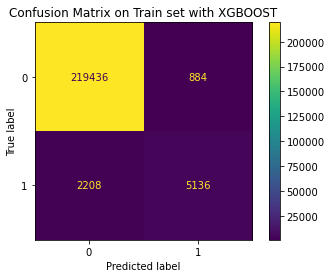

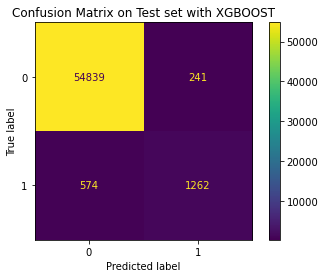

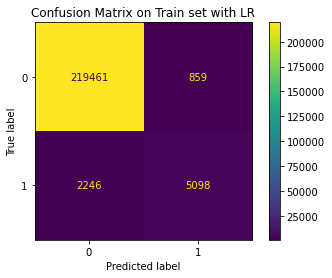

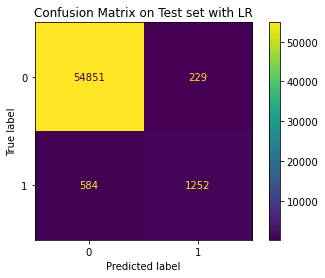

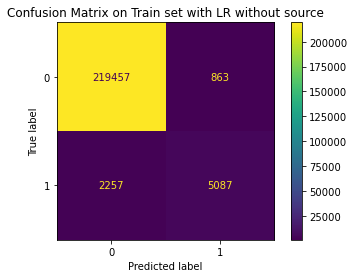

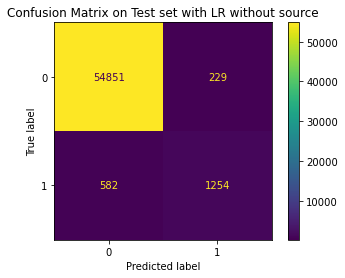

In [95]:
import matplotlib.pyplot as plt

best_models = {'XGBOOST' : best_estimators['XGBOOST'] ,
              'LR' : best_estimators['LR']}

for model_name,model in best_models.items():
 _ , ax = plt.subplots() # Get subplot from matplotlib
 ax.set(title=f"Confusion Matrix on Train set with {model_name}") # Set a title that we will add into ConfusionMatrixDisplay
 ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
 plt.show()

 _ , ax = plt.subplots() # Get subplot from matplotlib
 ax.set(title=f"Confusion Matrix on Test set with {model_name}") # Set a title that we will add into ConfusionMatrixDisplay
 ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
 plt.show()
    
model_name = 'LR without source'
model = best_estimators2['LR']

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title=f"Confusion Matrix on Train set with {model_name}") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_train3, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title=f"Confusion Matrix on Test set with {model_name}") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test3, y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

Conclusion: we get the best f1_score when we consider all the features or only eliminate the variable "source" and keep the other features.

We give recommendations to the newspaper.

In [96]:
pd.DataFrame(data = best_estimators['LR'].coef_.T,columns = ['coeficient'],index = X_train.columns).reset_index().rename(columns = {'index':'feature'})

,feature,coeficient
0,age,-0.595411
1,new_user,-1.693557
2,total_pages_visited,2.553946
3,China,-3.604852
4,Germany,0.165276
5,US,-0.376260
6,Direct,-0.198581
7,Seo,-0.045066


We recommend that readers of the newspaper view a large number of pages. We have observed that the probability of converting is higher among readers who are not new users, so we recommend that readers revisit the newspaper. On the other hand, the Chinese do not seem to be interested in converting, and in fact we do not recommend promoting the newspaper in China.

Predictions are made on the unlabeled dataset.

In [97]:
df_test = pd.read_csv('conversion_data_test.csv')

In [98]:
df_test.head()

,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3


In [99]:
X.columns

Index(['age', 'new_user', 'total_pages_visited', 'China', 'Germany', 'US',
       'Direct', 'Seo'],
      dtype='object')

We apply on df_test the same transformation of the categorical variables as on the dataset X.

In [100]:
cols_enc = [col for col in encoder_country.categories_[0]]

df_test = df_test.join(pd.DataFrame(encoder_country.transform(df_test[['country']]),columns = cols_enc))
                       
df_test = df_test.drop(columns = ["UK","country"])   

cols_enc = [col for col in encoder_source.categories_[0][1:]]

df_test = df_test.join(pd.DataFrame(encoder_source.transform(df_test[['source']]),columns = cols_enc))

df_test = df_test.drop(columns = "source")

df_test.head()

,age,new_user,total_pages_visited,China,Germany,US,Direct,Seo
0,28,0,16,0.0,0.0,0.0,0.0,1.0
1,22,1,5,0.0,0.0,0.0,1.0,0.0
2,32,1,1,1.0,0.0,0.0,0.0,1.0
3,32,1,6,0.0,0.0,1.0,0.0,0.0
4,25,0,3,1.0,0.0,0.0,0.0,1.0


In [101]:
X.head()

,age,new_user,total_pages_visited,China,Germany,US,Direct,Seo
0,22,1,2,1.0,0.0,0.0,1.0,0.0
1,21,1,3,0.0,0.0,0.0,0.0,0.0
2,20,0,14,0.0,1.0,0.0,0.0,1.0
3,23,1,3,0.0,0.0,1.0,0.0,1.0
4,28,1,3,0.0,0.0,1.0,1.0,0.0


Nous observons que les datasets X et df_test possèdent les mêmes features. Désormais on standarise les deux colonnes numériques.

In [102]:
df_test[['age','total_pages_visited']] = sc.transform(df_test[['age','total_pages_visited']])

In [103]:
df_test.head()

,age,new_user,total_pages_visited,China,Germany,US,Direct,Seo
0,-0.311324,0,3.328593,0.0,0.0,0.0,0.0,1.0
1,-1.036507,1,0.037432,0.0,0.0,0.0,1.0,0.0
2,0.172132,1,-1.159353,1.0,0.0,0.0,0.0,1.0
3,0.172132,1,0.336629,0.0,0.0,1.0,0.0,0.0
4,-0.673915,0,-0.560961,1.0,0.0,0.0,0.0,1.0


Nous réalisons les prédictions en utilisant le modèle qui possède le f1_score le plus élevé sur le test set, c'est à dire, 
xgboost du best_estimators.

In [104]:
best_estimators

{'LR': LogisticRegression(C=0.01, max_iter=1000, penalty='none'),
 'knn': KNeighborsClassifier(n_neighbors=50),
 'Random Forest': RandomForestClassifier(max_depth=10, min_samples_split=10),
 'Decision tree': DecisionTreeClassifier(),
 'XGBOOST': XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=200,
               n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, ...)}

In [105]:
classifier = best_estimators['XGBOOST']

data = {
    'converted': classifier.predict(df_test)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_MARECHAL.csv', index=False)